# Analyze Shakespeare and Company Project books dataset to estimate missing books

This notebook provides summary information about the book data, then uses Folgert Karsdorp and Mike Kestemont's python library [Copia](https://copia.readthedocs.io/en/latest/intro.html) to calculate abundance and diversity to estimate how much of the books the dataset cover; we then compare these calculations to estimates based on a handwritten tally from the Sylvia Beach archives from 1931.


In [1]:
import pandas as pd

# add project root to path so we can import utility methods
import sys
sys.path.append('..')

from utils.missing_data_processing import get_preprocessed_data


## Summary information about the book data 

- how many books total?
- how many books were borrowed at least once?
- how many books are 'uncertain'

*Note:* books that could not be positively identified by the Project team were flagged as uncertain; we exclude these from our analysis.

In [3]:
# load books and events datasets
data = get_preprocessed_data("books", "events") 
books_df = data["books"]
events_df = data["events"]

In [4]:
total_books = books_df.shape[0]

# identify borrowed books by non-zero borrow count
borrowed_books = books_df[books_df.borrow_count != 0]
total_borrowed_books = borrowed_books.shape[0]

# identify uncertain books by boolean flag
uncertain_books = books_df[books_df.uncertain].shape[0]

print(f"""{total_books:,} total books
{total_borrowed_books:,} borrowed books
{uncertain_books:,} uncertain books
{total_borrowed_books - uncertain_books:,} books that are not uncertain (i.e., identified titles)
""")

6,020 total books
5,683 borrowed books
475 uncertain books
5,208 books that are not uncertain (i.e., identified titles)



In [5]:
# brief view of book data; subset of columns only
books_df[['id', 'title', 'author', 'year', 'format', 'borrow_count', 'circulation_years']].head()

,id,title,author,year,format,borrow_count,circulation_years
0,malory-morte-darthur,Le Morte d'Arthur,"Malory, Thomas",1485.0,Book,7,1930;1932;1937;1938;1939
1,more-utopia,Utopia,"More, Thomas",1516.0,Book,2,1930;1950;1951
2,norton-gorboduc,Gorboduc,"Norton, Thomas",1561.0,Book,1,1950
3,lyly-euphues-anatomy-wit,Euphues: The Anatomy of Wit,"Lyly, John",1578.0,Book,1,1941
4,spenser-shepheards-calendar,The Shepheard's Calendar,"Spenser, Edmund",1579.0,Book,1,1941


### Which titles were borrowed most?

Periodicals, James Joyce, Dorothy Richardson

In [6]:
# sort by most borrowed; drop unborrowed titles
most_borrowed_books_df = borrowed_books.sort_values('borrow_count', ascending=False).reindex()
most_borrowed_books_df[['title', 'author', 'borrow_count']].head(10)

,title,author,borrow_count
5905,The New Statesman and Nation,NaN,115
5955,Time and Tide,NaN,109
5906,The New Yorker,NaN,72
1305,A Portrait of the Artist as a Young Man,"Joyce, James",56
1200,Dubliners,"Joyce, James",47
1271,Pointed Roofs (Pilgrimage 1),"Richardson, Dorothy M.",45
5854,The Criterion,NaN,42
1939,The Garden Party and Other Stories,"Mansfield, Katherine",37
4440,Mr. Norris Changes Trains,"Isherwood, Christopher",36
5583,Life and Letters,NaN,36


### Which titles were borrowed least?


In [7]:
most_borrowed_books_df[['title', 'borrow_count']].tail(10)

,title,borrow_count
3850,Once a Grand Duke,1
3851,Oriental Assembly,1
1433,Colors of Life: Poems and Songs and Sonnets,1
3854,Peril at End House,1
3855,Pigeon Irish,1
1430,Ardours and Endurances,1
3859,Satan's Circus and Other Stories,1
1428,Adolphe,1
3861,Save Me the Waltz,1
6019,Zola,1


In [8]:
single_borrows = borrowed_books[borrowed_books.borrow_count == 1].shape[0]
print(f"{single_borrows:,} books borrowed only once")

2,031 books borrowed only once


In [9]:
# filter event data to just the borrowing activity
borrows = events_df[events_df.event_type == 'Borrow']

# how many borrow events?
total_borrows = borrows.shape[0]
# how many unique items were borrowed?
unique_titles = len(borrows.item_id.unique())
print(f"""{total_borrows:,} borrowing events
{unique_titles:,} unique titles borrowed
""")

21,059 borrowing events
5,683 unique titles borrowed



In [10]:
# preview of event data, subset of fields only
borrows[['start_date', 'end_date', 'member_names', 'item_title']].head(10)

,start_date,end_date,member_names,item_title
2,1922,1922-08-23,Mr. Rhys,Typhoon
8,1923,1923-11-07,Eyre de Lanux / Mrs. Pierre de Lanux,Night and Day
12,1924,1924-10-22,Simone Téry,James Joyce
13,1924,1924-10-22,Simone Téry,A Portrait of George Moore in a Study of His Work
22,1926,1926-01-14,Ada (Hitchcock) MacLeish;Archibald MacLeish,Tents of Israel
38,1929,1929-03-13,Elvira de Alvear,Later Poems
46,1931,1931-01-10,James Joyce,A History of Theatrical Art in Ancient and Mod...
51,1931,1931-01-10,James Joyce,Poems of Walter Scott
52,1931,1931-01-10,James Joyce,The Horse-Stealers and Other Stories
53,1931,1931-01-10,James Joyce,The Crock of Gold


## Use Copia to calculate abundance data for borrowed titles

Analyze books with [Copia](https://copia.readthedocs.io/en/latest/intro.html), by Folgert Karsdorp and Mike Kestemont.

We treat each borrow event as a "species sighting" or sampling of that title. Copia aggregrates and calculates how many time each item was sighted.




In [12]:
from copia.utils import to_abundance
from copia.stats import basic_stats

abundance = to_abundance(borrows.item_id)


In [13]:
stats = basic_stats(abundance)

print(f"""
Statistics:

F1: {stats['f1']:,} (singletons)
F2: {stats['f2']:,} (doubletons)
F3: {stats['f3']:,}
F4: {stats['f4']:,}

Seen: {stats['S']:,}
Total: {stats['n']:,}""")



Statistics:

F1: 2,031 (singletons)
F2: 1,099 (doubletons)
F3: 673
F4: 468

Seen: 5,683
Total: 21,059


### Plot the abundance data

<Axes: title={'center': 'Distribution of borrow events over books'}, xlabel='Books', ylabel='Borrow events'>

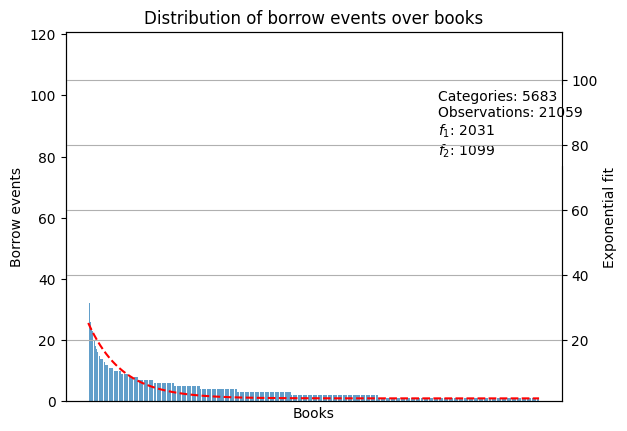

In [14]:
from copia.plot import abundance_counts

# plot abundance counts with a trendline and with custom labels
abundance_counts(abundance, trendline=True, xlabel="Books", ylabel="Borrow events",
        title='Distribution of borrow events over books')


<Axes: title={'center': 'Distribution of borrow events over books'}, xlabel='Books', ylabel='Borrow events'>

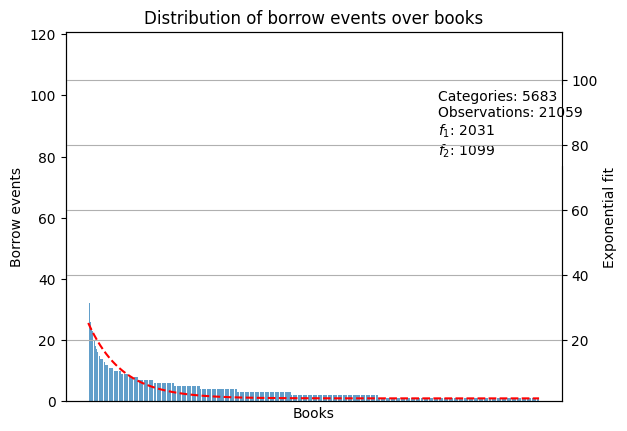

In [15]:
import matplotlib.pyplot as plt

from copia.plot import abundance_histogram

abundance_counts(abundance, trendline=True, xlabel="Books", ylabel="Borrow events",
        title='Distribution of borrow events over books')

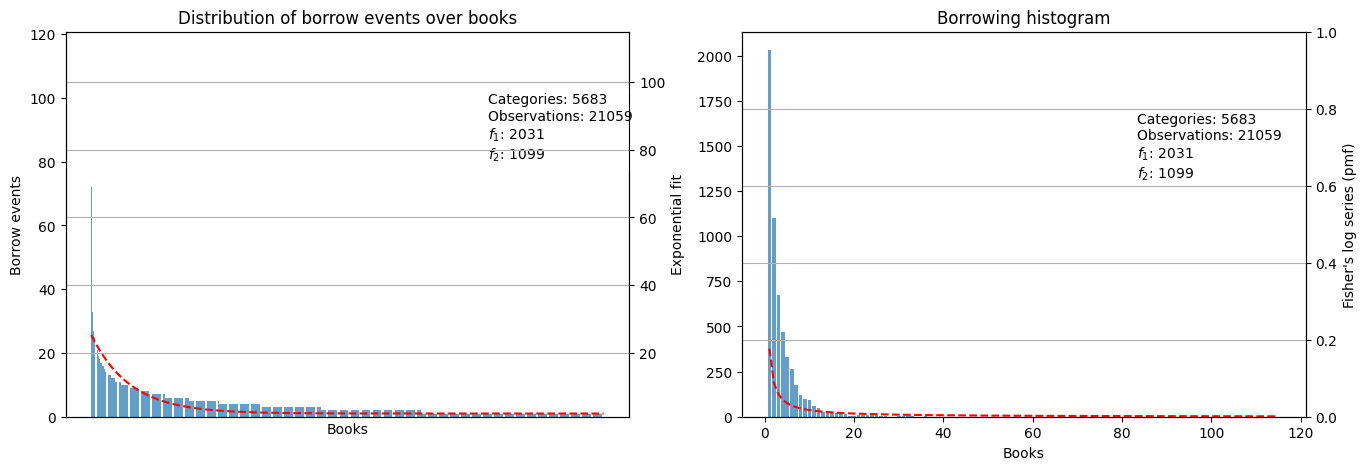

In [16]:
# use subplot to combine the two charts

fig, axes = plt.subplots(1, 2, figsize=(16,5))

abundance_counts(abundance, trendline=True, xlabel="Books", ylabel="Borrow events",
        title='Distribution of borrow events over books', ax=axes[0])

abundance_histogram(abundance, trendline=True, xlabel='Books',
        title='Borrowing histogram', ax=axes[1])

plt.show()

In [17]:
# save the figure
fig.savefig("book_abundance_distribution_combined.png", dpi=300)

### Use Copia to estimate diversity

In [18]:
from copia.richness import diversity
import numpy as np


for m in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(m, '->', diversity(abundance, method=m))

chao1 -> 7559.599237308967
ichao1 -> 8005.677519255238
ace -> 7434.960110335195
jackknife -> 9437.0
egghe_proot -> 8580.905546555845


In [19]:
print('species richness:', diversity(abundance, method='empirical'))
print('population size:', diversity(abundance, method='empirical', species=False))

species richness: 5683
population size: 21059


In [20]:
%%capture
results = diversity(abundance, method='chao1', CI=True)

In [21]:
print(f"""diversity - chao1

richness {results['richness']}
lci {results['lci']}
uci {results['uci']}
std {results['std']}
""")

diversity - chao1

richness 7559.599237308967
lci 7381.427880392671
uci 7733.03044962332
std 88.44382559116939



In [22]:
results = diversity(abundance, method='jackknife', CI=True)
print(f"""diversity - jackknife

richness {results['richness']}
lci {results['lci']}
uci {results['uci']}
""")

diversity - jackknife

richness 9437.0
lci 8858.727581202922
uci 10015.272418797078



In [23]:
print('Empirical size:', diversity(abundance, method='empirical', species=False))
print('Unbiased estimate:', diversity(abundance, method='minsample'))

Empirical size: 21059
Unbiased estimate: 229206.36414736416


In [24]:
%%capture
results = diversity(abundance, method='minsample', CI=True, n_iter=10)


/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 0.6349744593644573 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 1.2551226676805527 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 0.43217108838871354 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 1.580045695292938 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/worka

In [25]:
print(f"""diversity - minsample

richness {results['richness']}
lci {results['lci']}
uci {results['uci']}
""")

diversity - minsample

richness 229206.36414736416
lci 215654.04173504174
uci 238383.30640180642



*NOTE:* We don't calculate species accumulation because it is too slow with our data.

## Estimate diversity of books by unique borrowers

The first estimates were based on pure borrow count; what if we look at number of unique borrowers instead?

This would collapse repeat borrows by the same library member, and would consolidate different events that were part of the same multi-volume work.

In [26]:
# get unique book/person combination
uniq_borrows = borrows[['member_uris', 'item_id']].drop_duplicates()

In [27]:
uniq_borrow_book_counts = uniq_borrows.groupby('item_id').count().reset_index().rename(columns={'member_uris': 'borrower_count'}).sort_values('borrower_count', ascending=False)
uniq_borrow_book_counts.head(10)

,item_id,borrower_count
2717,joyce-portrait-artist-young,50
2710,joyce-dubliners,45
4209,richardson-pointed-roofs,40
3294,mansfield-garden-party-stories,34
2570,isherwood-mr-norris-changes,33
1769,forster-passage-india,33
3292,mansfield-bliss-short-stories,31
5582,woolf-mrs-dalloway,31
2711,joyce-exiles,30
2942,lawrence-women-love,29


In [28]:
print(f"""{uniq_borrows.shape[0]:,} unique book/person borrow events
{len(uniq_borrows.item_id.unique()):,} unique titles
""")

19,315 unique book/person borrow events
5,683 unique titles



In [29]:
uniq_abundance = to_abundance(uniq_borrows.item_id)

In [30]:
stats = basic_stats(uniq_abundance)

print(f"""
Statistics:

F1: {stats['f1']:,} (singletons)
F2: {stats['f2']:,} (doubletons)
F3: {stats['f3']:,}
F4: {stats['f4']:,}

Seen: {stats['S']:,}
Total: {stats['n']:,}""")


Statistics:

F1: 2,124 (singletons)
F2: 1,126 (doubletons)
F3: 699
F4: 459

Seen: 5,683
Total: 19,315


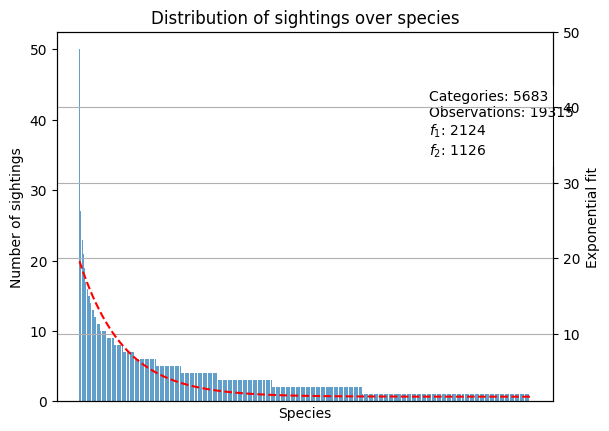

In [31]:
abundance_counts(uniq_abundance, trendline=True);

<Axes: title={'center': 'Sightings histogram'}, xlabel='Species'>

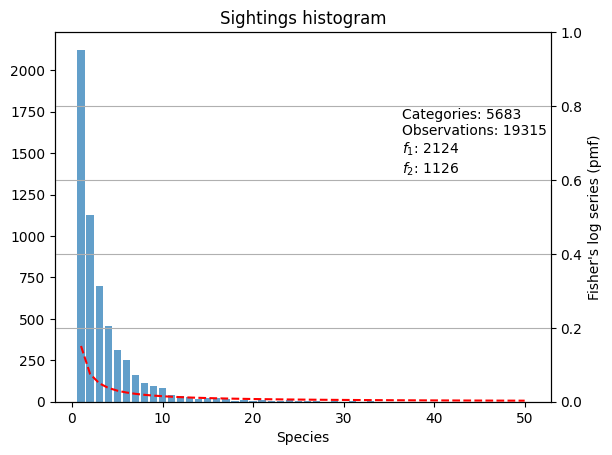

In [32]:
abundance_histogram(uniq_abundance, trendline=True)

In [33]:
for m in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(m, '->', diversity(uniq_abundance, method=m))

chao1 -> 7686.171594794905
ichao1 -> 8168.398184995255
ace -> 7600.631267610415
jackknife -> 9760.0
egghe_proot -> 8679.130291384008


In [34]:
print('species richness:', diversity(uniq_abundance, method='empirical'))
print('population size:', diversity(uniq_abundance, method='empirical', species=False))

species richness: 5683
population size: 19315


In [35]:
%%capture
results = diversity(uniq_abundance, method='minsample', CI=True, n_iter=10)

/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 0.6325714466074714 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 0.9254834787061554 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 1.9333286904220586 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/workarea/env/shxco_missing_data/lib/python3.9/site-packages/copia/richness.py:530: UserWarning: Tolerance criterion not met: 1.0160413989797235 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/Users/rkoeser/worka

In [36]:
print(f"""diversity - minsample

richness {results['richness']}
lci {results['lci']}
uci {results['uci']}
std {results['std']}
""")

diversity - minsample

richness 215441.63762663765
lci 204704.0803765804
uci 223271.60844410848
std 5924.265334080672



In [37]:
uniq_diagn = diversity(uniq_abundance, method='minsample',
                        solver='grid', CI=False, # CI must be False for this use!
                        diagnostics=True)
print(f"""diversity - minsample

richness {uniq_diagn['richness']}
x* {uniq_diagn['x*']}
n {uniq_diagn['n']}
""")

diversity - minsample

richness 215441.63762663765
x* 10.154110154110155
n 19315



In [38]:
assert np.isclose(uniq_diagn['richness'],
                  uniq_diagn['n'] + (uniq_diagn['x*'] * uniq_diagn['n']),
                  atol=0.001)

### Re-estimate diversity/abundance but exclude uncertain titles


In [39]:
uncertain_books_df = books_df[books_df.uncertain]
uncertain_books_df[['id', 'title', 'notes']].head(10)

,id,title,notes
1154,miscellaneous-pieces,Miscellaneous Pieces,Unidentified. Likely Ralph Waldo Emerson's *Mi...
1312,epictetus,Epictetus,Unidentified. By or about Epictetus.
5300,12-30-heaven,12:30 from Heaven,Unidentified. Likely Freeman Wills Crofts's [*...
5302,abc-language,ABC of Language,Unidentified. Lending library card includes th...
5303,abraham-lincoln,Abraham Lincoln,Unidentified. By or about Lincoln. Dolly Wilde...
5304,bundle-reviews,[a bundle of reviews],Unidentified. A note on the lending library ca...
5305,certain-man,A Certain Man,Unidentified. Bryan T. Holland's *A Certain Ma...
5307,swinburne-2,"A. C. Swinburne, Gosse",Unidentified. Edmund Gosse's *The Life of Alge...
5308,addison,Addison,Unidentified. By or about Joseph Addison. Lend...
5310,adventures-sir-walter,Adventures of Sir Walter Raleigh,Unidentified. In *Hemingway's Reading 1910–194...


In [40]:
# exclude borrow events for uncertain titles
certain_borrows = borrows[~borrows.item_id.isin(uncertain_books_df.id)]
print(f'{certain_borrows.shape[0]:,} borrows for identified titles only')

20,316 borrows for identified titles only


In [41]:
certainborrow_abundance = abundance = to_abundance(certain_borrows.item_id)

In [42]:
stats = basic_stats(certainborrow_abundance)

print(f"""
Statistics:

F1: {stats['f1']:,} (singletons)
F2: {stats['f2']:,} (doubletons)
F3: {stats['f3']:,}
F4: {stats['f4']:,}

Seen: {stats['S']:,}
Total: {stats['n']:,}""")


Statistics:

F1: 1,754 (singletons)
F2: 1,026 (doubletons)
F3: 649
F4: 457

Seen: 5,269
Total: 20,316


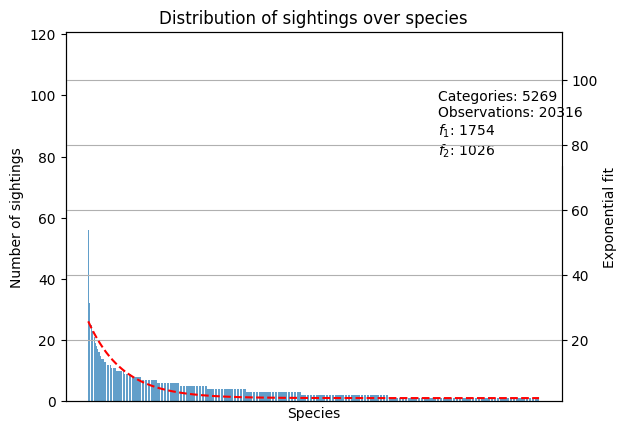

In [43]:
abundance_counts(certainborrow_abundance, trendline=True);

<Axes: title={'center': 'Sightings histogram'}, xlabel='Species'>

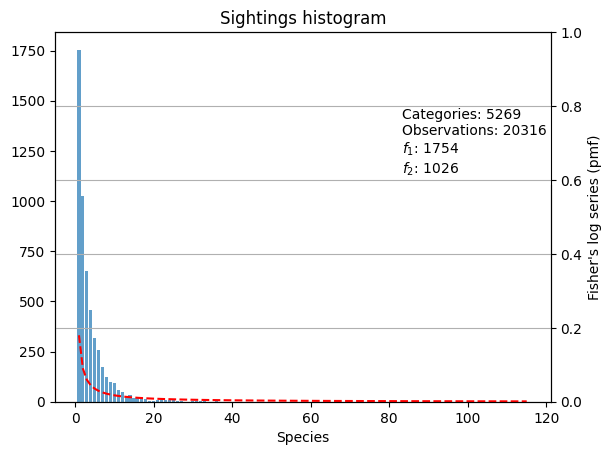

In [44]:
abundance_histogram(certainborrow_abundance, trendline=True)

In [45]:
for m in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(m, '->', diversity(certainborrow_abundance, method=m))

chao1 -> 6768.203005284536
ichao1 -> 7132.27945405853
ace -> 6699.942174325335
jackknife -> 8102.000000000001
egghe_proot -> 7629.49793475749


In [46]:
%%capture 
results = diversity(certainborrow_abundance, method='chao1', CI=True, n_iter=10)

In [47]:
print(f"""diversity - chao1

richness {results['richness']}
lci {results['lci']}
uci {results['uci']}
std {results['std']}
""")

diversity - chao1

richness 6768.203005284536
lci 6615.536119136482
uci 6918.44033015238
std 84.94071267856879



In [48]:
results = diversity(certainborrow_abundance, method='jackknife', CI=True)

In [49]:
print(f"""diversity - jackknife

richness {results['richness']}
lci {results['lci']}
uci {results['uci']}
""")

diversity - jackknife

richness 8102.000000000001
lci 7771.108387372204
uci 8432.891612627798



In [50]:
diagn = diversity(certainborrow_abundance, method='minsample',
                        solver='grid', CI=False, # CI must be False for this use!
                        diagnostics=True)
print(f"""diversity - minsample, CI

richness {diagn['richness']}
x* {diagn['x*']}
n {diagn['n']}
""")

diversity - minsample, CI

richness 201949.348033348
x* 8.94040894040894
n 20316



In [51]:
assert np.isclose(diagn['richness'],
                  diagn['n'] + (diagn['x*'] * diagn['n']),
                  atol=0.001)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 530.13it/s]


<Axes: ylabel='Density (KDE)'>

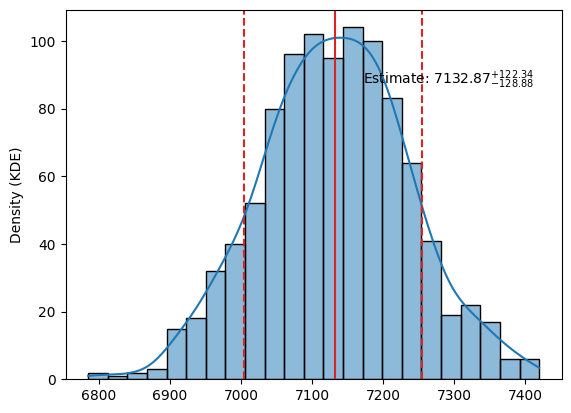

In [52]:
from copia.plot import density
estimate = diversity(certainborrow_abundance, method='iChao1', CI=True)
density(estimate)

<Axes: ylabel='Density (KDE)'>

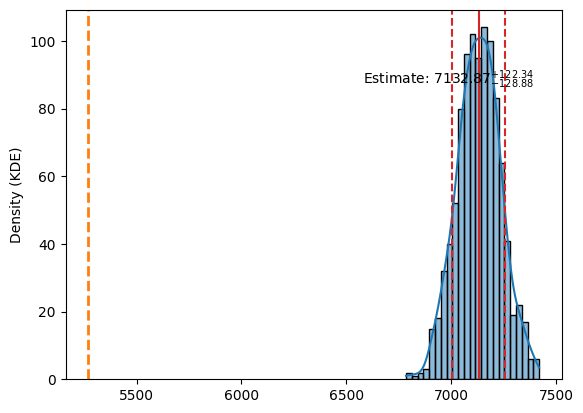

In [53]:
empirical = diversity(certainborrow_abundance, method='empirical')
density(estimate, empirical)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 534.26it/s]


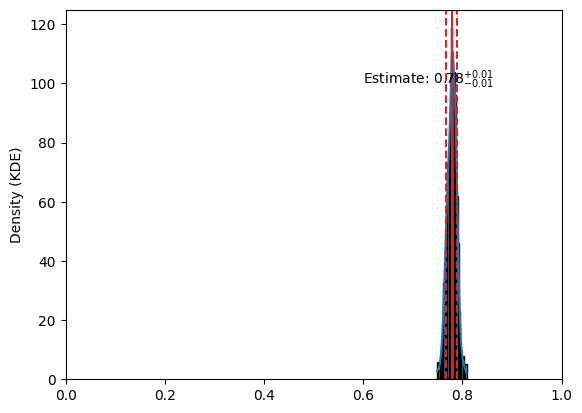

In [54]:
from copia.utils import survival_ratio
survival = survival_ratio(abundance, method='chao1')
density(survival, xlim=(0, 1));

In [55]:
%%capture

from copia.hill import hill_numbers
emp, est = hill_numbers(abundance, n_iter=10)

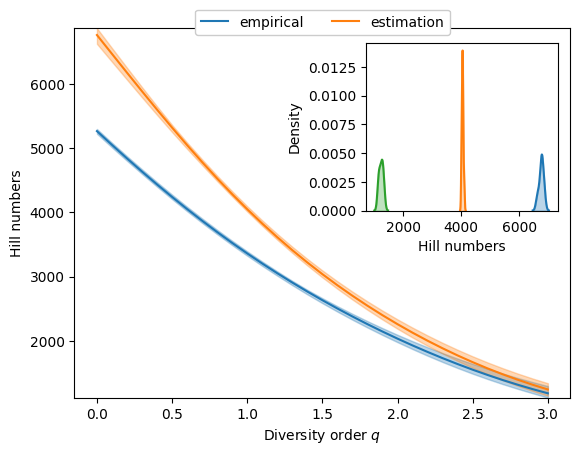

In [56]:
import copia.plot as plot
plot.hill_plot(emp, est);

### Based on these estimates, what percent of books does the dataset include?


In [57]:
certain_titles = 5269

In [58]:
# all borrow events for certain titles

chao1 = 6768
chao1_upper = 6943
chao1_lower = 6628

In [59]:
print(f'''chao1
total estimate:    {chao1:,}  (upper {chao1_upper:,}; lower {chao1_lower:,})
missing titles:    {chao1 - certain_titles:,}  (upper {chao1_upper - certain_titles:,}; lower {chao1_lower - certain_titles:,})
percent surviving: {certain_titles/chao1 * 100:.2f}% (upper {certain_titles/chao1_upper * 100:.2f}%; lower {certain_titles/chao1_lower * 100:.2f}%)
''')

chao1
total estimate:    6,768  (upper 6,943; lower 6,628)
missing titles:    1,499  (upper 1,674; lower 1,359)
percent surviving: 77.85% (upper 75.89%; lower 79.50%)



In [60]:
jackknife = 8102
jackknife_upper = 8432
jackknife_lower = 7771

In [61]:
print(f'''jackknife
percent surviving: {certain_titles/jackknife * 100:.2f}% (upper {certain_titles/jackknife_upper * 100:.2f}%; lower {certain_titles/jackknife_lower * 100:.2f}%)
''')

jackknife
percent surviving: 65.03% (upper 62.49%; lower 67.80%)



In [62]:
# minsample
minsample_borrows = 201949
actual_borrows = 20316
actual_borrows / minsample_borrows


0.10059965634888016

hmm, but we know we have more than 10% of borrowing activity


In [63]:
# unique borrowers for certain titles
chao1 = 6873
chao1_upper = 6950
chao1_lower = 6775

In [64]:
print(f'''chao1 - unique borrows for certain titles

total estimate:    {chao1:,}  (upper {chao1_upper:,}; lower {chao1_lower:,})
percent surviving: {certain_titles/chao1 * 100:.2f}% (upper {certain_titles/chao1_upper * 100:.2f}%; lower {certain_titles/chao1_lower * 100:.2f}%)
''')

chao1 - unique borrows for certain titles

total estimate:    6,873  (upper 6,950; lower 6,775)
percent surviving: 76.66% (upper 75.81%; lower 77.77%)



In [65]:
jackknife = 8567
jackknife_upper = 9128
jackknife_lower = 8005

In [66]:
print(f'''jackknife - unique borrows for certain titles

percent surviving: {certain_titles/jackknife * 100:.2f}% (upper {certain_titles/jackknife_upper * 100:.2f}%; lower {certain_titles/jackknife_lower * 100:.2f}%)
''')

jackknife - unique borrows for certain titles

percent surviving: 61.50% (upper 57.72%; lower 65.82%)



In [67]:
uniq_borrow_minsample = 189648
actual_borrows / uniq_borrow_minsample

0.10712477853707922

## Compare these estimates to Beach's handwritten tally from 1931

Based on a handwritten tally in the Beach papers, we know that there were 4,600 books in February 1931. 

In [68]:
from datetime import date

# parse start date so we can compare
# filter out unknown dates and unknown years
borrows = borrows[borrows.start_date.notna()]
borrows = borrows[~borrows.start_date.str.startswith('--')]
borrows['start_date_dt'] = pd.to_datetime(borrows['start_date'], format='ISO8601')

# get all borrows up to February 28 1931
pretally_borrows = borrows[borrows.start_date_dt <= pd.to_datetime(date(1931, 2, 28))]

# how many unique books?
print(f"{len(pretally_borrows.item_id.unique()):,} unique titles borrowed before February 28 1931")

2,874 unique titles borrowed before February 28 1931


In [69]:
# where the items returned?
pretally_borrows.borrow_status.value_counts()

borrow_status
Returned    6426
Unknown      190
Name: count, dtype: int64

In [70]:
# what about only the books that were returned?
len(pretally_borrows[pretally_borrows.borrow_status == 'Returned'].item_id.unique())

2809

Group borrow events by titles and determine the last known status for each title,
since a book may have been returned multiple times before being lost or bought.

In [71]:
# sort by start date
sorted_pretally_borrows = pretally_borrows.sort_values('start_date_dt', ascending=True)
sorted_pretally_borrows[['start_date', 'item_id', 'borrow_status']].head(10)


,start_date,item_id,borrow_status
674,1919-11-18,wilde-profundis,Returned
675,1919-11-18,hardy-trumpet-major,Returned
673,1919-11-18,meredith-diana-crossways,Returned
678,1919-11-19,james-roderick-hudson,Returned
680,1919-11-19,hazlitt-characters-shakespeares-plays,Returned
683,1919-11-22,wells-passionate-friends,Unknown
684,1919-11-22,kipling-many-inventions,Returned
685,1919-11-22,james-roderick-hudson,Returned
686,1919-11-24,butler-pigs-pigs,Returned
687,1919-11-25,conrad-lord-jim,Returned


In [72]:
# drop duplicates based only on item id; keep the last entry
pretally_borrow_laststatus = sorted_pretally_borrows.drop_duplicates(subset=['item_id'], keep='last')
pretally_borrow_laststatus[['start_date', 'item_id', 'borrow_status']].head(10)

,start_date,item_id,borrow_status
686,1919-11-24,butler-pigs-pigs,Returned
701,1919-12-01,arens-playboy-portfolio-art,Unknown
705,1919-12-02,webster-white-devil,Returned
706,1919-12-02,unclear-ile,Returned
713,1919-12-04,harte-idyls-foothills-prose,Returned
714,1919-12-04,thompson-shelley,Returned
719,1919-12-13,gilbert-bab-ballads,Returned
723,1919-12-15,harris-uncle-remus-songs,Returned
728,1919-12-19,eastman-colors-life-poems,Returned
729,1919-12-19,irwin-letters-japanese-schoolboy,Unknown


In [73]:
pretally_borrow_laststatus.borrow_status.value_counts()

borrow_status
Returned    2765
Unknown      109
Name: count, dtype: int64

In [74]:
pretally_borrow_laststatus[pretally_borrow_laststatus.borrow_status == 'Returned'][['start_date', 'item_id', 'borrow_status']].head(10)

,start_date,item_id,borrow_status
686,1919-11-24,butler-pigs-pigs,Returned
705,1919-12-02,webster-white-devil,Returned
706,1919-12-02,unclear-ile,Returned
713,1919-12-04,harte-idyls-foothills-prose,Returned
714,1919-12-04,thompson-shelley,Returned
719,1919-12-13,gilbert-bab-ballads,Returned
723,1919-12-15,harris-uncle-remus-songs,Returned
728,1919-12-19,eastman-colors-life-poems,Returned
732,1919-12-20,masefield-tarpaulin-muster,Returned
745,1919-12-30,noguchi-american-diary-japanese,Returned


What is the number of books we know to have been returned before this date?


In [75]:
# double check
len(pretally_borrow_laststatus[pretally_borrow_laststatus.borrow_status == 'Returned'].item_id.unique())

2765

What is the ratio between the returned books in the dataset and Beach's tally?

In [76]:
2765 / 4600

0.6010869565217392

## Run copia on the later time period

We know that more of the borrowing activity from the 1930s is preserved. Do the estimates change if we run on borrowing activity after September 1932 ?

In [77]:
certain_borrows = borrows[~borrows.item_id.isin(uncertain_books_df.id)]

In [78]:
def get_best_date(row):
  # dates are strings; return the longest
  start_date_len = len(row.start_date) if pd.notna(row.start_date) else 0
  end_date_len = len(row.end_date) if pd.notna(row.end_date) else 0

  if start_date_len > end_date_len:
    return row.start_date
  else:
    return row.end_date

# get either start or end date, whichever we find first

certain_borrows['date'] = certain_borrows.apply(get_best_date, axis=1)
certain_borrows[['start_date', 'end_date', 'date']].head()

,start_date,end_date,date
2,1922,1922-08-23,1922-08-23
8,1923,1923-11-07,1923-11-07
13,1924,1924-10-22,1924-10-22
22,1926,1926-01-14,1926-01-14
38,1929,1929-03-13,1929-03-13


In [79]:
certain_borrows['date_dt'] = pd.to_datetime(certain_borrows.date, errors='coerce')

In [80]:
# catalog borrows ? or post 1933 ?
# February 17 1931 to September 25 1932 (586 days)
# let's just do after this gap

from datetime import date

range_start = pd.to_datetime(date(1932, 9, 26))

later_borrows = certain_borrows[certain_borrows.date_dt >= range_start]
later_borrows[['start_date', 'end_date', 'member_names', 'item_title']].head(10)

,start_date,end_date,member_names,item_title
121,1934,1934-11-16,Catherine Marie Knight Peake / Mrs. Charles Pe...,James Joyce and the Making of Ulysses
140,1936,1936-12-04,Suzanne Mespoulet,"Restoration Comedy, 1660 – 1720"
149,1937,1937-06-01,Fernand Colens,The Friendly Tree
150,1937,1937-12-08,Fanny Rirachowsky,Poems
152,1937,1937-12-08,Fanny Rirachowsky,The Home and the World
153,1937,1937-12-08,Fanny Rirachowsky,Lady into Fox
154,1937,1937-12-08,Fanny Rirachowsky,Green Hills of Africa
155,1937,1937-12-08,Fanny Rirachowsky,Manhattan Transfer
156,1938,1938-06-23,Thérèse Bertrand-Fontaine,To Wake the Dead
167,1938,1938-12-06,Antoinette Bernheim,The Crock of Gold


In [81]:
later_abundance = to_abundance(later_borrows.item_id)

<Axes: title={'center': 'Distribution of sightings over species'}, xlabel='Species', ylabel='Number of sightings'>

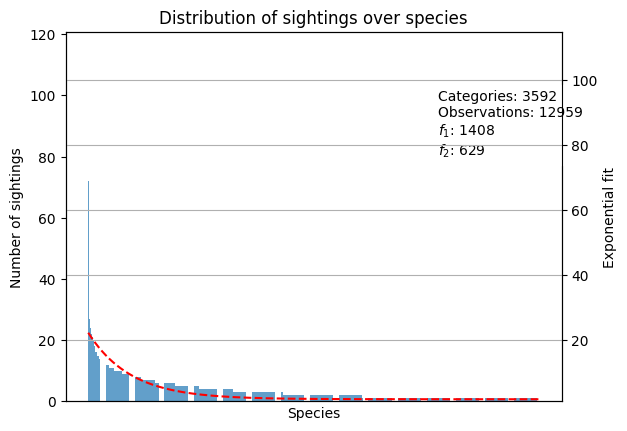

In [82]:
abundance_counts(later_abundance, trendline=True)

<Axes: title={'center': 'Sightings histogram'}, xlabel='Species'>

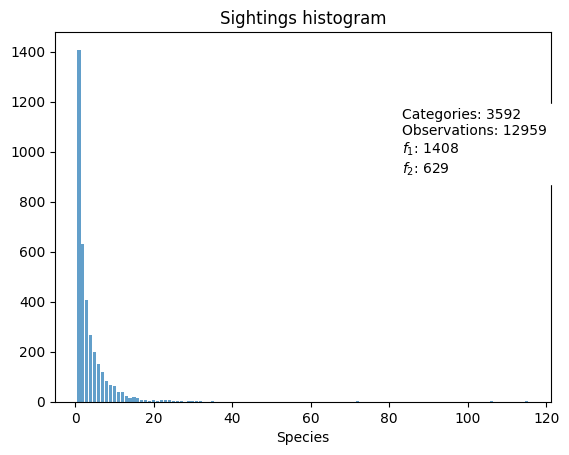

In [83]:
abundance_histogram(later_abundance)

In [84]:
from copia.richness import diversity

later_estimates = {}

for m in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot', 'minsample'):
    later_estimates[m] = diversity(later_abundance, method=m)
    print(m, '->', later_estimates[m])

chao1 -> 5167.763927102365
ichao1 -> 5522.0812553330525
ace -> 4863.909359421397
jackknife -> 7264.000000000002
egghe_proot -> 6066.362907982511
minsample -> 165074.48591548592


In [85]:
print('species richness:', diversity(later_abundance, method='empirical'))
print('population size:', diversity(later_abundance, method='empirical', species=False))

species richness: 3592
population size: 12959


In [86]:
print('Empirical size:', diversity(later_abundance, method='empirical', species=False))
print('Unbiased estimate:', diversity(later_abundance, method='minsample'))

Empirical size: 12959
Unbiased estimate: 165074.48591548592


In [87]:
print(diversity(later_abundance, method='minsample', solver='fsolve'))
print(diversity(later_abundance, method='minsample', solver='grid'))

Diff_intersect: inf
165074.48591548592
165074.48591548592


In [88]:
diagn = diversity(later_abundance, method='minsample',
                        solver='grid', CI=False, # CI must be False for this use!
                        diagnostics=True)
print(diagn)

{'richness': 165074.48591548592, 'x*': 11.738211738211739, 'n': 12959}


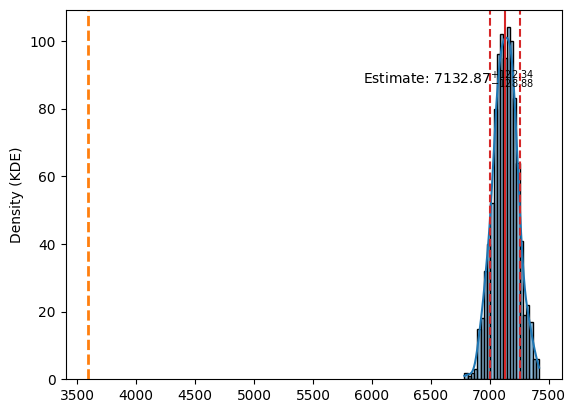

In [89]:
empirical = diversity(later_abundance, method='empirical')
density(estimate, empirical);

In [90]:
%%capture
emp, est = hill_numbers(later_abundance, n_iter=10)

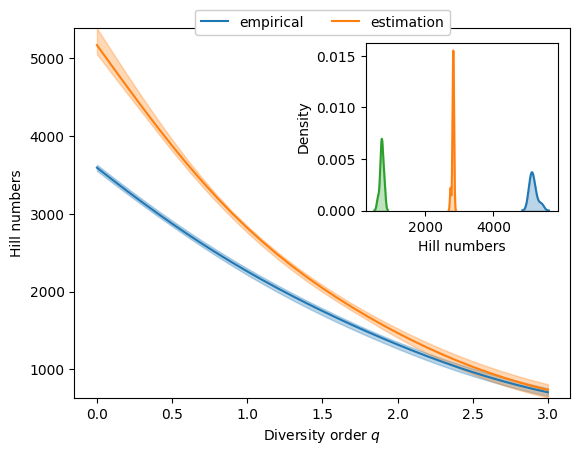

In [91]:
plot.hill_plot(emp, est);

In [92]:
# what percent do these numbers give us for this time period?
later_period_items = len(later_borrows.item_id.unique())
later_period_items

3592

In [93]:
# estimates = {
# 'chao1':  5177.974780621821,
# 'ichao1': 5533.397781689817,
# 'ace': 4877.040161073133,
# 'jackknife': 7281.000000000002,
# 'egghe_proot': 6075.0994294919265,
# }

for algo, est in later_estimates.items():
  print('%s : %.2f%%' % (algo, later_period_items / est * 100))


chao1 : 69.51%
ichao1 : 65.05%
ace : 73.85%
jackknife : 49.45%
egghe_proot : 59.21%
minsample : 2.18%
